In [1]:
# Importar bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

# Configurações
plt.style.use('default')
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [2]:
# Carregar o dataset Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(f"Formato dos dados de treino: {x_train.shape}")
print(f"Formato dos dados de teste: {x_test.shape}")
print(f"Valores min/max dos pixels: {x_train.min()}-{x_train.max()}")

# Normalizar os dados para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Redimensionar para formato adequado para CNNs (adicionar canal)
x_train_reshaped = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Manter também versão flat para compatibilidade
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(f"Formato para CNN: {x_train_reshaped.shape}")
print(f"Formato flat: {x_train_flat.shape}")

# Nomes das classes Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Formato dos dados de treino: (60000, 28, 28)
Formato dos dados de teste: (10000, 28, 28)
Valores min/max dos pixels: 0-255
Formato para CNN: (60000, 28, 28, 1)
Formato flat: (60000, 784)


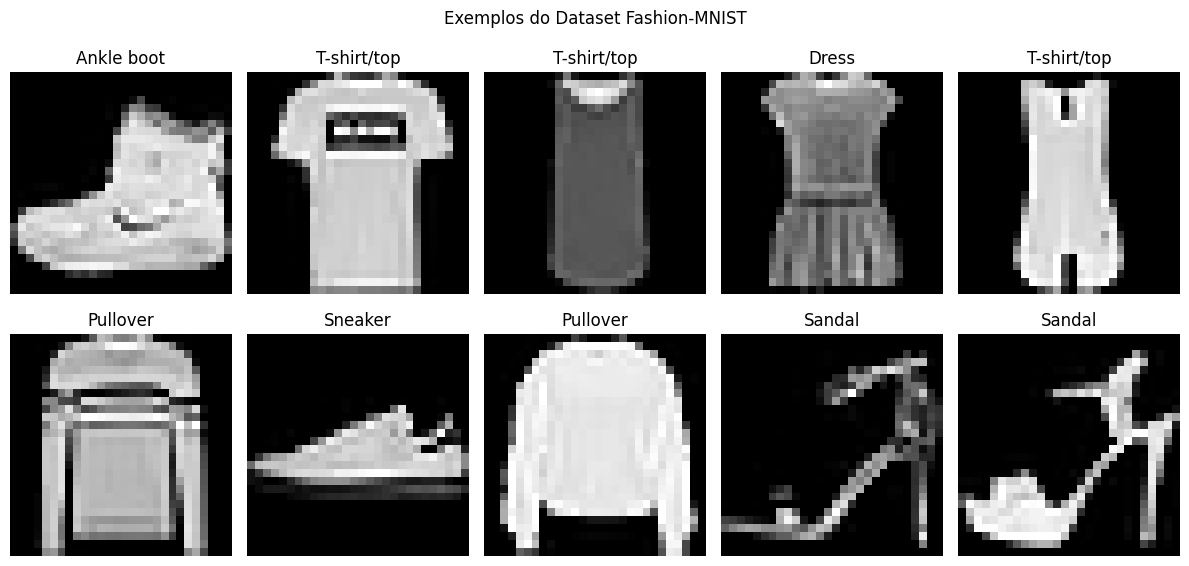

In [3]:
# Visualizar algumas imagens do dataset
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'{class_names[y_train[i]]}')
    plt.axis('off')
plt.suptitle('Exemplos do Dataset Fashion-MNIST')
plt.tight_layout()
plt.show()

In [4]:
# Definir a arquitetura do Autoencoder Convolucional
input_img = keras.Input(shape=(28, 28, 1))

# Encoder - Convolução com downsampling
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 7x7
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4x128 (bottleneck)

print(f"Forma da representação codificada: {encoded.shape}")

# Decoder - Deconvolução com upsampling
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)  # 8x8
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16
x = layers.Conv2D(32, (3, 3), activation='relu')(x)  # Remove padding para ajustar tamanho
x = layers.UpSampling2D((2, 2))(x)  # 32x32
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# Camada final para reconstruir a imagem
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# # Ajustar o tamanho final para 28x28
# decoded = layers.Cropping2D(cropping=((2, 2), (2, 2)))(decoded)  # Crop de 32x32 para 28x28

# Criar o modelo autoencoder
autoencoder_conv = keras.Model(input_img, decoded, name='autoencoder_convolucional')

# Compilar o modelo
autoencoder_conv.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Resumo da arquitetura
autoencoder_conv.summary()

Forma da representação codificada: (None, 4, 4, 128)


Model: "autoencoder_convolucional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,049 (1.30 MB)

 Trainable params: 342,049 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Treinar o Autoencoder Convolucional
print("Treinando o Autoencoder Convolucional...")

# Definir callbacks
early_stopping_conv = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

reduce_lr_conv = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Treinar o modelo (entrada = saída desejada para autoencoder)
history_conv = autoencoder_conv.fit(
    x_train_reshaped, x_train_reshaped,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_reshaped, x_test_reshaped),
    callbacks=[early_stopping_conv, reduce_lr_conv],
    verbose=1
)

print("Treinamento concluído!")

Treinando o Autoencoder Convolucional...
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0395 - mae: 0.1196 - val_loss: 0.0126 - val_mae: 0.0578 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0117 - mae: 0.0550 - val_loss: 0.0095 - val_mae: 0.0488 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0092 - mae: 0.0475 - val_loss: 0.0081 - val_mae: 0.0443 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0079 - mae: 0.0436 - val_loss: 0.0074 - val_mae: 0.0424 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0072 - mae: 0.0414 - val_loss: 0.0070 - val_mae: 0.0415 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0066 - mae: 0.0395 - val_loss: 0.0062 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0062 - mae: 0.0381 - val_loss: 0.00

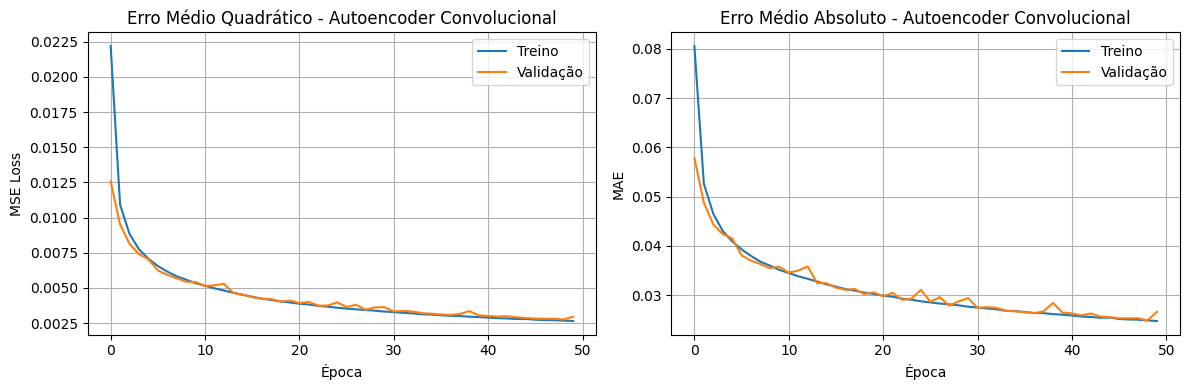

In [6]:
# Plotar curvas de treinamento do Autoencoder Convolucional
plt.figure(figsize=(12, 4))

# Perda (Loss)
plt.subplot(1, 2, 1)
plt.plot(history_conv.history['loss'], label='Treino')
plt.plot(history_conv.history['val_loss'], label='Validação')
plt.title('Erro Médio Quadrático - Autoencoder Convolucional')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Erro Médio Absoluto
plt.subplot(1, 2, 2)
plt.plot(history_conv.history['mae'], label='Treino')
plt.plot(history_conv.history['val_mae'], label='Validação')
plt.title('Erro Médio Absoluto - Autoencoder Convolucional')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Testando o Autoencoder Convolucional...


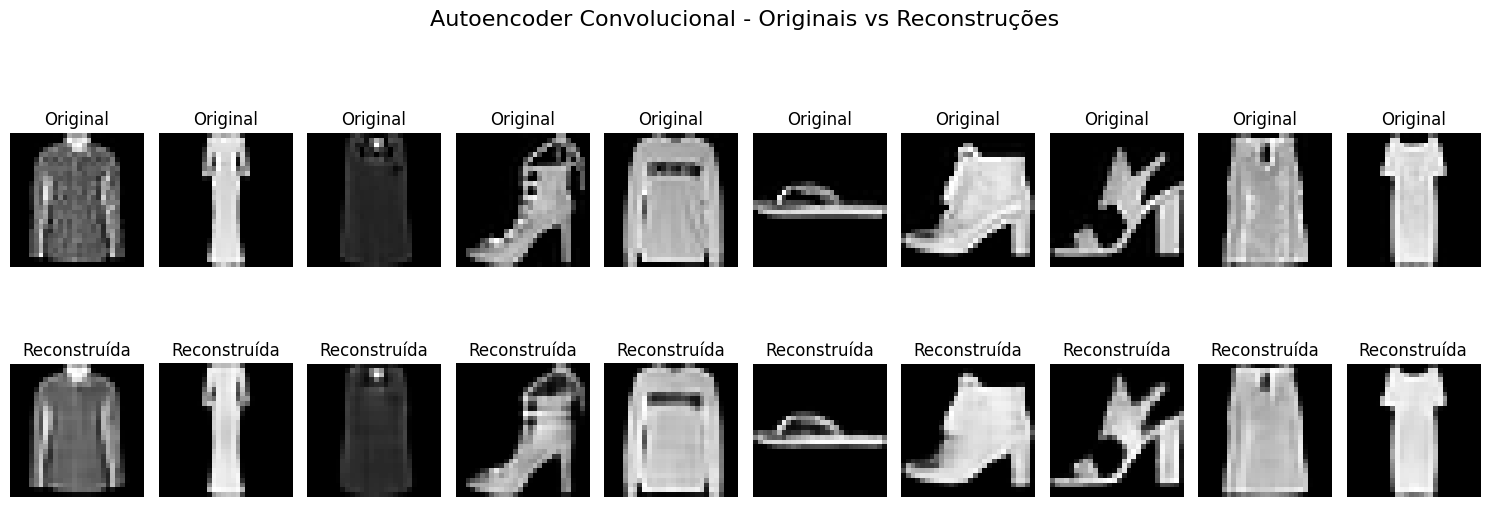

MSE médio das reconstruções: 0.002219
Desvio padrão do MSE: 0.001472


In [7]:
# Testar o Autoencoder Convolucional - Reconstrução de 10 imagens
print("Testando o Autoencoder Convolucional...")

# Selecionar 10 imagens aleatórias do conjunto de teste
np.random.seed(42)
test_indices = np.random.choice(len(x_test), 10, replace=False)
test_images_2d = x_test_reshaped[test_indices]

# Fazer predições (reconstruções)
reconstructed_conv = autoencoder_conv.predict(test_images_2d, verbose=0)

# Visualizar resultados
plt.figure(figsize=(15, 6))
for i in range(10):
    # Imagem original
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_images_2d[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Imagem reconstruída
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_conv[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstruída')
    plt.axis('off')

plt.suptitle('Autoencoder Convolucional - Originais vs Reconstruções', fontsize=16)
plt.tight_layout()
plt.show()

# Calcular MSE médio das reconstruções
mse_scores_conv = np.mean((test_images_2d - reconstructed_conv) ** 2, axis=(1, 2, 3))
print(f"MSE médio das reconstruções: {np.mean(mse_scores_conv):.6f}")
print(f"Desvio padrão do MSE: {np.std(mse_scores_conv):.6f}")

# Denoising Autoencoder

Agora vamos implementar um autoencoder que remove ruído das imagens. O objetivo é treinar o modelo para reconstruir imagens limpas a partir de imagens com ruído.

Formato dos dados 2D com ruído: (60000, 28, 28, 1)
Formato dos dados flat com ruído: (60000, 784)
Fator de ruído aplicado: 0.3


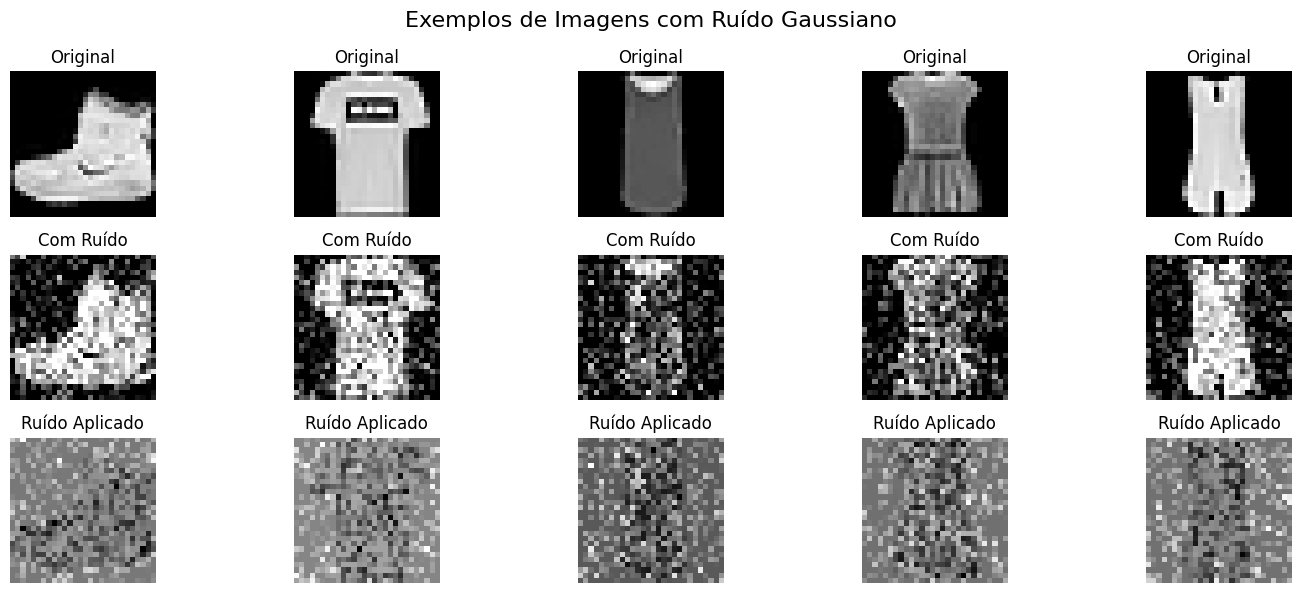

In [8]:
# Função para adicionar ruído gaussiano às imagens
def add_noise(images, noise_factor=0.3):
    """
    Adiciona ruído gaussiano às imagens
    Args:
        images: array de imagens
        noise_factor: intensidade do ruído (0.0 = sem ruído, 1.0 = muito ruído)
    """
    noise = np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise_factor * noise
    # Clipar valores para manter no intervalo [0, 1]
    noisy_images = np.clip(noisy_images, 0.0, 1.0)
    return noisy_images

# Criar versões com ruído dos dados de treino e teste (2D para CNN)
noise_factor = 0.3
x_train_noisy_2d = add_noise(x_train_reshaped, noise_factor)
x_test_noisy_2d = add_noise(x_test_reshaped, noise_factor)

# Manter também versão flat para compatibilidade
x_train_noisy = add_noise(x_train_flat, noise_factor)
x_test_noisy = add_noise(x_test_flat, noise_factor)

print(f"Formato dos dados 2D com ruído: {x_train_noisy_2d.shape}")
print(f"Formato dos dados flat com ruído: {x_train_noisy.shape}")
print(f"Fator de ruído aplicado: {noise_factor}")

# Visualizar exemplos de imagens com ruído
plt.figure(figsize=(15, 6))
for i in range(5):
    # Imagem original
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Imagem com ruído
    plt.subplot(3, 5, i + 6)
    plt.imshow(x_train_noisy_2d[i].reshape(28, 28), cmap='gray')
    plt.title('Com Ruído')
    plt.axis('off')

    # Diferença (ruído)
    plt.subplot(3, 5, i + 11)
    diff = x_train_noisy_2d[i].reshape(28, 28) - x_train[i]
    plt.imshow(diff, cmap='gray')
    plt.title('Ruído Aplicado')
    plt.axis('off')

plt.suptitle('Exemplos de Imagens com Ruído Gaussiano', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
# Definir a arquitetura do Denoising Autoencoder Convolucional
input_img_noisy = keras.Input(shape=(28, 28, 1))

# Encoder - mais robusto para lidar com ruído
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_noisy)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 7x7
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Dropout(0.25)(x)  # Dropout para regularização
encoded_denoising = layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4x128

print(f"Forma da representação codificada (denoising): {encoded_denoising.shape}")

# Decoder - reconstrói imagem limpa
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_denoising)
x = layers.Dropout(0.25)(x)
x = layers.UpSampling2D((2, 2))(x)  # 8x8
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16
x = layers.Conv2D(32, (3, 3), activation='relu')(x)  # Remove padding
x = layers.UpSampling2D((2, 2))(x)  # 32x32
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# Camada final para reconstruir a imagem limpa
decoded_denoising = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Ajustar o tamanho final para 28x28
# decoded_denoising = layers.Cropping2D(cropping=((2, 2), (2, 2)))(decoded_denoising)

# Criar o modelo denoising autoencoder
denoising_autoencoder_conv = keras.Model(input_img_noisy, decoded_denoising, name='denoising_autoencoder_conv')

# Compilar o modelo
denoising_autoencoder_conv.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Resumo da arquitetura
denoising_autoencoder_conv.summary()

Forma da representação codificada (denoising): (None, 4, 4, 128)


Model: "denoising_autoencoder_conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,049 (1.30 MB)

 Trainable params: 342,049 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Treinar o Denoising Autoencoder Convolucional
print("Treinando o Denoising Autoencoder Convolucional...")

# Definir callbacks
early_stopping_denoising = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# Treinar o modelo
# Entrada: imagens 2D com ruído, Saída: imagens 2D originais (sem ruído)
history_denoising_conv = denoising_autoencoder_conv.fit(
    x_train_noisy_2d, x_train_reshaped,  # Entrada com ruído, saída limpa
    epochs=60,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_2d, x_test_reshaped),  # Validação com ruído -> limpo
    callbacks=[early_stopping_denoising, reduce_lr],
    verbose=1
)

print("Treinamento do Denoising Autoencoder Convolucional concluído!")

Treinando o Denoising Autoencoder Convolucional...
Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0404 - mae: 0.1250 - val_loss: 0.0158 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0156 - mae: 0.0663 - val_loss: 0.0134 - val_mae: 0.0652 - learning_rate: 0.0010
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0137 - mae: 0.0615 - val_loss: 0.0123 - val_mae: 0.0620 - learning_rate: 0.0010
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0128 - mae: 0.0591 - val_loss: 0.0119 - val_mae: 0.0613 - learning_rate: 0.0010
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0122 - mae: 0.0576 - val_loss: 0.0114 - val_mae: 0.0596 - learning_rate: 0.0010
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0118 - mae: 0.0563 - val_loss: 0.0110 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0115 - mae: 0.0556 - val

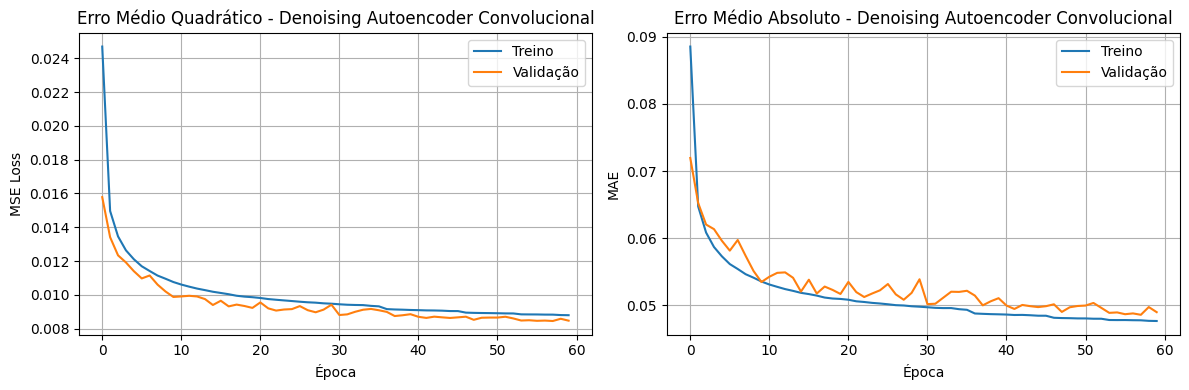

In [13]:
# Plotar curvas de treinamento do Denoising Autoencoder Convolucional
plt.figure(figsize=(12, 4))

# Perda (Loss)
plt.subplot(1, 2, 1)
plt.plot(history_denoising_conv.history['loss'], label='Treino')
plt.plot(history_denoising_conv.history['val_loss'], label='Validação')
plt.title('Erro Médio Quadrático - Denoising Autoencoder Convolucional')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Erro Médio Absoluto
plt.subplot(1, 2, 2)
plt.plot(history_denoising_conv.history['mae'], label='Treino')
plt.plot(history_denoising_conv.history['val_mae'], label='Validação')
plt.title('Erro Médio Absoluto - Denoising Autoencoder Convolucional')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Testando o Denoising Autoencoder Convolucional...


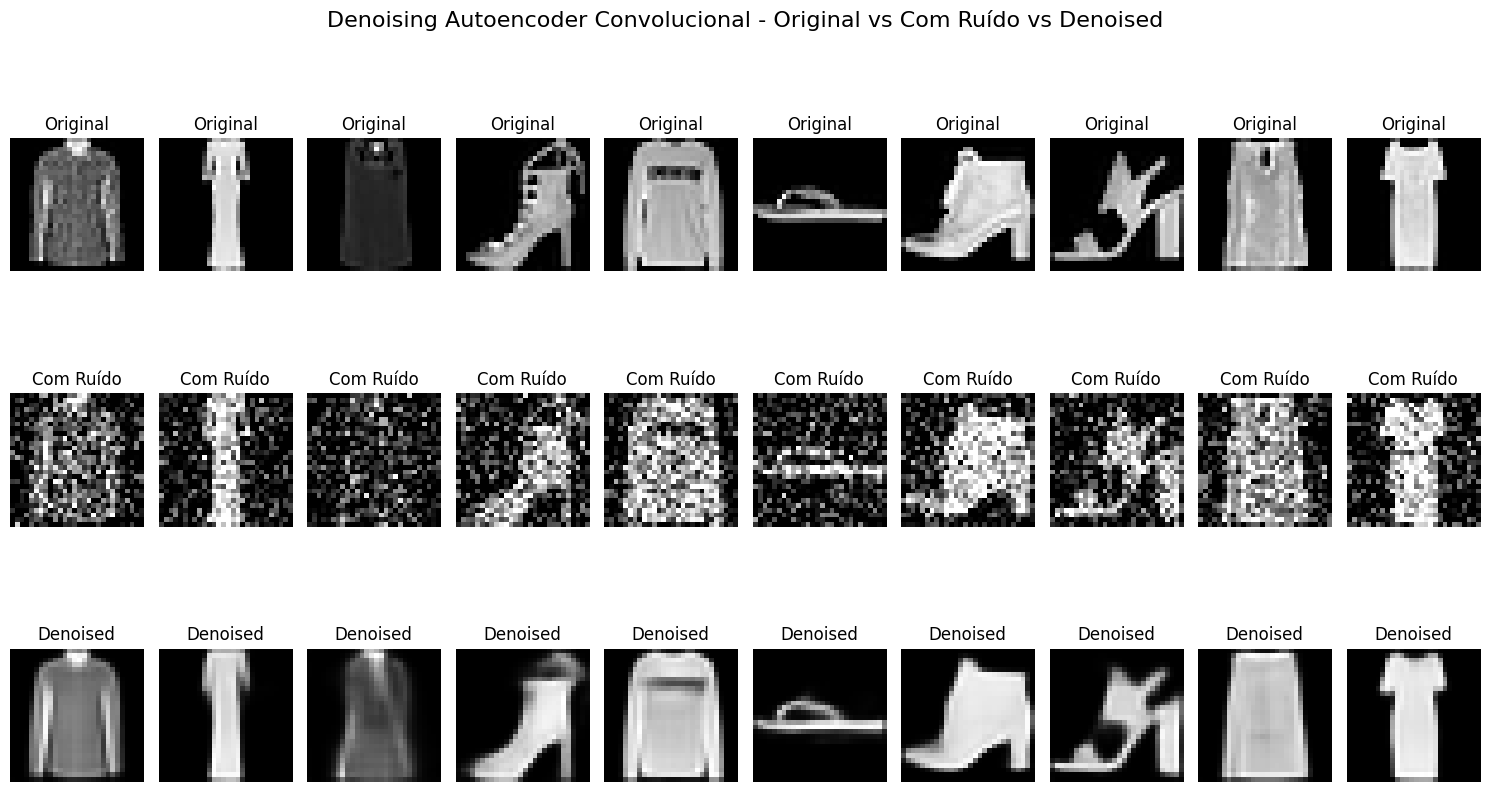

MSE médio (imagem com ruído vs original): 0.053054
MSE médio (imagem denoised vs original): 0.007480
Melhoria relativa: 85.90%


In [14]:
# Testar o Denoising Autoencoder Convolucional com as mesmas 10 imagens
print("Testando o Denoising Autoencoder Convolucional...")

# Usar as mesmas imagens do teste anterior, mas com ruído (2D)
test_images_noisy_2d = x_test_noisy_2d[test_indices]
test_images_original_2d = x_test_reshaped[test_indices]

# Fazer predições (denoising)
denoised_conv = denoising_autoencoder_conv.predict(test_images_noisy_2d, verbose=0)

# Visualizar resultados
plt.figure(figsize=(15, 9))
for i in range(10):
    # Imagem original (sem ruído)
    plt.subplot(3, 10, i + 1)
    plt.imshow(test_images_original_2d[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Imagem com ruído
    plt.subplot(3, 10, i + 11)
    plt.imshow(test_images_noisy_2d[i].reshape(28, 28), cmap='gray')
    plt.title('Com Ruído')
    plt.axis('off')

    # Imagem denoised (reconstruída)
    plt.subplot(3, 10, i + 21)
    plt.imshow(denoised_conv[i].reshape(28, 28), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

plt.suptitle('Denoising Autoencoder Convolucional - Original vs Com Ruído vs Denoised', fontsize=16)
plt.tight_layout()
plt.show()

# Calcular métricas de performance
mse_noisy_vs_original_conv = np.mean((test_images_noisy_2d - test_images_original_2d) ** 2, axis=(1, 2, 3))
mse_denoised_vs_original_conv = np.mean((denoised_conv - test_images_original_2d) ** 2, axis=(1, 2, 3))

print(f"MSE médio (imagem com ruído vs original): {np.mean(mse_noisy_vs_original_conv):.6f}")
print(f"MSE médio (imagem denoised vs original): {np.mean(mse_denoised_vs_original_conv):.6f}")
print(f"Melhoria relativa: {(1 - np.mean(mse_denoised_vs_original_conv)/np.mean(mse_noisy_vs_original_conv))*100:.2f}%")

=== COMPARAÇÃO DOS MODELOS CONVOLUCIONAIS ===

Autoencoder Convolucional:
  - MSE em imagens limpas: 0.002219
  - Parâmetros treináveis: 342,049

Denoising Autoencoder Convolucional:
  - MSE em imagens limpas: 0.006382
  - MSE em imagens com ruído: 0.007480
  - Parâmetros treináveis: 342,049

=== VANTAGENS DAS CONVOLUÇÕES ===
1. Preservação da estrutura espacial das imagens
2. Menos parâmetros devido ao compartilhamento de pesos
3. Invariância translacional - detecta padrões em qualquer posição
4. Melhor captura de características locais e globais
5. Upsampling/Downsampling gradual preserva detalhes


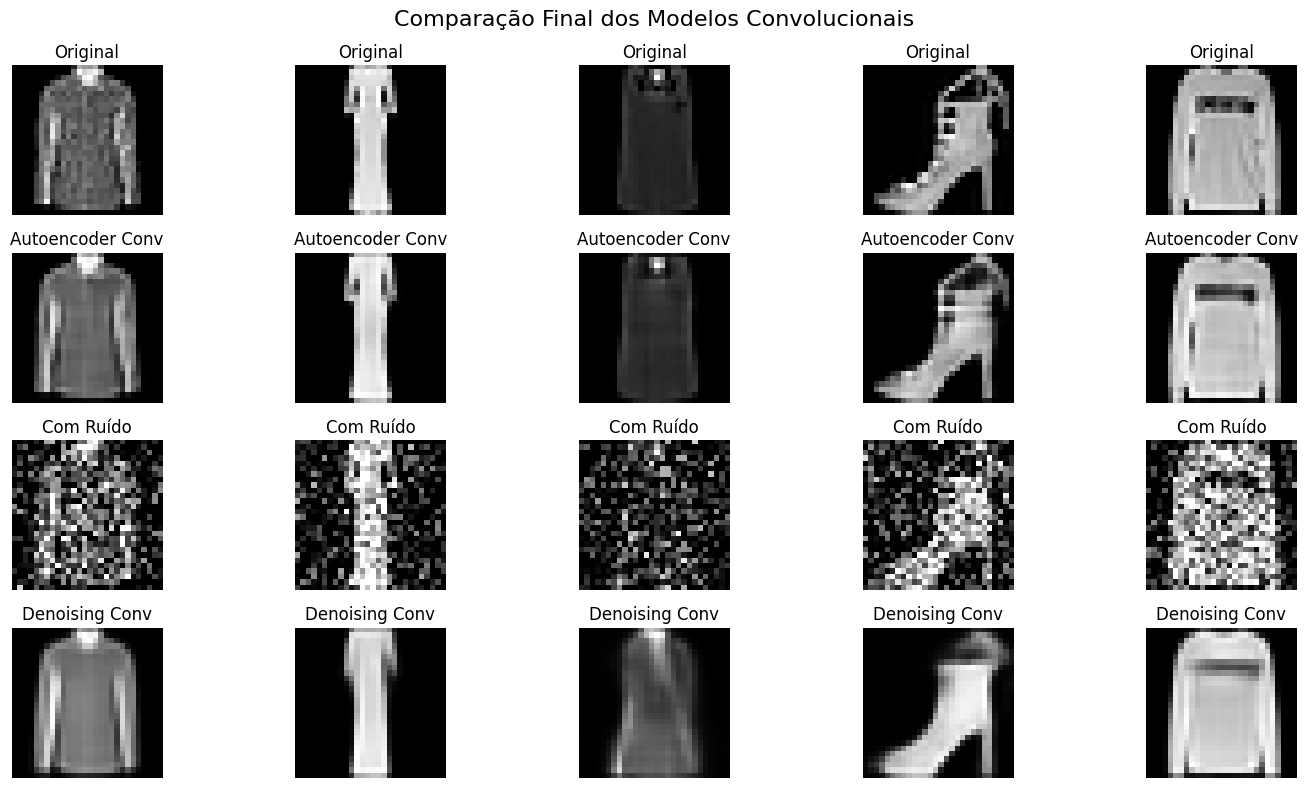


=== RESUMO TÉCNICO ===
• Compressão: 28×28×1 → 4×4×128 → 28×28×1
• Taxa de compressão: 0.4x menor na representação latente
• Arquitetura: Conv2D + MaxPooling (encoder) + Conv2D + UpSampling (decoder)

Modelos salvos como 'autoencoder_conv_fashion_mnist.h5' e 'denoising_autoencoder_conv_fashion_mnist.h5'


In [ ]:
# Comparação Final dos Dois Modelos Convolucionais
print("=== COMPARAÇÃO DOS MODELOS CONVOLUCIONAIS ===\n")

# Testar ambos os modelos nas mesmas imagens
autoencoder_reconstructions_conv = autoencoder_conv.predict(test_images_original_2d, verbose=0)
denoising_reconstructions_conv = denoising_autoencoder_conv.predict(test_images_original_2d, verbose=0)

# Calcular MSE para ambos
mse_basic_conv = np.mean((autoencoder_reconstructions_conv - test_images_original_2d) ** 2)
mse_denoising_clean_conv = np.mean((denoising_reconstructions_conv - test_images_original_2d) ** 2)

print(f"Autoencoder Convolucional:")
print(f"  - MSE em imagens limpas: {mse_basic_conv:.6f}")
print(f"  - Parâmetros treináveis: {autoencoder_conv.count_params():,}")

print(f"\nDenoising Autoencoder Convolucional:")
print(f"  - MSE em imagens limpas: {mse_denoising_clean_conv:.6f}")
print(f"  - MSE em imagens com ruído: {np.mean(mse_denoised_vs_original_conv):.6f}")
print(f"  - Parâmetros treináveis: {denoising_autoencoder_conv.count_params():,}")

print(f"\n=== VANTAGENS DAS CONVOLUÇÕES ===")
print("1. Preservação da estrutura espacial das imagens")
print("2. Menos parâmetros devido ao compartilhamento de pesos")
print("3. Invariância translacional - detecta padrões em qualquer posição")
print("4. Melhor captura de características locais e globais")
print("5. Upsampling/Downsampling gradual preserva detalhes")

# Visualização final comparativa
plt.figure(figsize=(15, 8))
for i in range(5):
    # Original
    plt.subplot(4, 5, i + 1)
    plt.imshow(test_images_original_2d[i].reshape(28, 28), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Autoencoder convolucional
    plt.subplot(4, 5, i + 6)
    plt.imshow(autoencoder_reconstructions_conv[i].reshape(28, 28), cmap='gray')
    plt.title('Autoencoder Conv')
    plt.axis('off')

    # Com ruído
    plt.subplot(4, 5, i + 11)
    plt.imshow(test_images_noisy_2d[i].reshape(28, 28), cmap='gray')
    plt.title('Com Ruído')
    plt.axis('off')

    # Denoising autoencoder convolucional
    plt.subplot(4, 5, i + 16)
    plt.imshow(denoised_conv[i].reshape(28, 28), cmap='gray')
    plt.title('Denoising Conv')
    plt.axis('off')

plt.suptitle('Comparação Final dos Modelos Convolucionais', fontsize=16)
plt.tight_layout()
plt.show()



print(f"\n=== RESUMO TÉCNICO ===")
print(f"• Compressão: 28×28×1 → 4×4×128 → 28×28×1")
print(f"• Taxa de compressão: {(28*28)/(4*4*128):.1f}x menor na representação latente")
print(f"• Arquitetura: Conv2D + MaxPooling (encoder) + Conv2D + UpSampling (decoder)")

# Salvar os modelos
autoencoder_conv.save('autoencoder_conv_fashion_mnist.keras')
denoising_autoencoder_conv.save('denoising_autoencoder_conv_fashion_mnist.keras')
print("\nModelos salvos como 'autoencoder_conv_fashion_mnist.keras' e 'denoising_autoencoder_conv_fashion_mnist.keras'")